In [84]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch.nn.functional as F

In [85]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [86]:
import gc
gc.collect()

4121

In [87]:
print("Total memory allocated:", torch.cuda.memory_allocated(device) / 1e9, "GB")
print("Total memory cached   :", torch.cuda.memory_cached(device) / 1e9, "GB")

Total memory allocated: 0.100354048 GB
Total memory cached   : 0.159383552 GB


In [88]:
mat = scipy.io.loadmat('notMNIST_small.mat')
mat.keys()


dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])

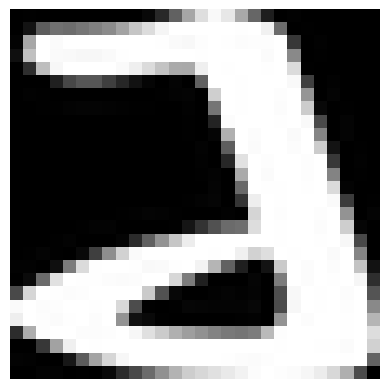

In [89]:
mat['images'].shape

plt.imshow(mat['images'][:, :, 1], cmap='gray')
plt.axis('off')
plt.show()

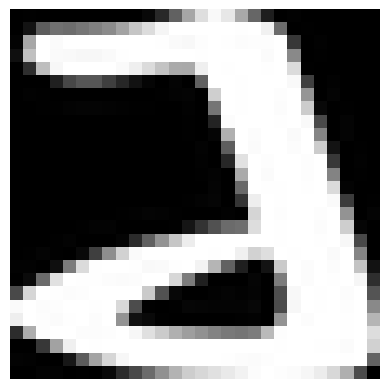

(18724, 28, 28)

In [90]:
new_img = np.random.rand(18724, 28, 28)
for index in range(mat['images'].shape[2]):
    new_img[index] = mat['images'][:,:,index]

plt.imshow(new_img[1, :, :], cmap='gray')
plt.axis('off')
plt.show()

new_img.shape

In [91]:
indices = np.arange(18724)
np.random.shuffle(indices)
labels = np.array(mat['labels'])


shuffled_images = new_img[indices]
shuffled_labels = labels[indices]

In [92]:
x_train_img = np.array(shuffled_images[0:11234, :,:])
x_test_img = np.array(shuffled_images[11235:18724, :,:])
y_train_label = np.array(shuffled_labels[0:11234])
y_test_label =np.array(shuffled_labels[11235:18724])

x_train_img.shape

(11234, 28, 28)

In [93]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

 
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [94]:
test_images = x_test_img
test_labels = y_test_label

test_dataset = CustomDataset(test_images, test_labels)

test_loader = DataLoader(dataset=test_dataset, shuffle=False)

In [95]:
from torch.utils.data import DataLoader

images = x_train_img
labels = y_train_label

custom_dataset = CustomDataset(images, labels)

data_loader = DataLoader(dataset=custom_dataset, batch_size=32, shuffle=True)


In [96]:
def normalized_tanh(x):
    return (torch.tanh(x) + 1) / 2

In [97]:
class SimpleCNN_x(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN_x, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(5760, 1024)
        #self.fc3 = nn.Linear(1024*8, 1024)  # This might need adjustment
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):

        x1 = self.pool(F.leaky_relu(self.conv1(x)))
        x2 = F.leaky_relu(self.conv2(x1))
        x3 = self.pool(x2)
        x4 = self.pool(F.leaky_relu(self.conv3(x3)))
        x5 = x4.view(x4.size(0), -1)
        xx = torch.cat([x5, torch.sin(x5)
        , torch.cos(x5), torch.sin(2 * x5), torch.cos(2 * x5)], dim=1)

        xx = self.dropout(xx)
        x6 = F.leaky_relu(self.fc1(xx))
        x6 = self.dropout(x6)
        out = self.fc2(x6)
        
        return x1, x2, out

In [98]:
# class SimpleCNN_x(nn.Module):
#     def __init__(self, num_classes=10):  
#         super(SimpleCNN_x, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#         #self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.fc1 = nn.Linear(15680, 1024)
#         #self.fc3 = nn.Linear(1024*8, 1024)  # This might need adjustment
#         self.fc2 = nn.Linear(1024, num_classes)

#     def forward(self, x):

#         x1 = self.pool(F.leaky_relu(self.conv1(x)))
#         x2 = F.leaky_relu(self.conv2(x1))
#         x3 = self.pool(x2)
    
#         #x4 = self.pool(F.leaky_relu(self.conv3(x3)))
    
#        #x4 = self.dropout(x4)
               
#         x5 = x3.view(x3.size(0), -1)
#         xx = torch.cat([x5, torch.sin(x5)
#         , torch.cos(x5), torch.sin(2 * x5), torch.cos(2 * x5)], dim=1)

#         xx = self.dropout(xx)
#         x6 = F.leaky_relu(self.fc1(xx))
#         x6 = self.dropout(x6)
#         out = self.fc2(x6)
        
#         return x1, x2, out

In [99]:
# mdlx = SimpleCNN_x(num_classes=10) 
# criterion = nn.CrossEntropyLoss()  
# optimizer = torch.optim.SGD(mdlx.parameters(), lr=0.001, momentum=0.8)

# mdlx = mdlx.to(device)

# num_epochs = 30  
# epoch_losses = []

# for epoch in range(num_epochs):
#     epoch_loss = 0
#     num_batches = 0

#     for i, (images, labels) in enumerate(data_loader):
#         images, labels = images.to(device), labels.to(device)
#         images = images.unsqueeze(1)
        
#         x1, x2, outputs = mdlx(images)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         num_batches += 1

#         if (i+1) % 100 == 0:
#             print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

#     epoch_loss /= num_batches
#     epoch_losses.append(epoch_loss)

# plt.plot(epoch_losses)
# plt.ylabel('Average Epoch Loss')
# plt.xlabel('Epoch')
# plt.title('Loss over Epochs')
# plt.show()


In [100]:
# def test_model_x(mdlx, test_loader):
#     mdlx = mdlx.to(device)
    
#     mdlx.eval() 
#     correct = 0
#     total = 0

#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
        
#         images = images.unsqueeze(1)  
#         x1, x2, outputs = mdlx(images)
#         _, predicted = torch.max(outputs.data, 1)  
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Accuracy: {accuracy:.2f}%')


# test_model_x(mdlx, test_loader)

In [101]:
x_train_img = np.array(shuffled_images[0:14979, :,:])
x_test_img = np.array(shuffled_images[14980:18724, :,:])
y_train_label = np.array(shuffled_labels[0:14979])
y_test_label =np.array(shuffled_labels[14980:18724])

x_train_img.shape

(14979, 28, 28)

In [102]:
test_images = x_test_img
test_labels = y_test_label

test_dataset = CustomDataset(test_images, test_labels)

test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

images = x_train_img
labels = y_train_label

custom_dataset = CustomDataset(images, labels)

data_loader = DataLoader(dataset=custom_dataset, batch_size=32, shuffle=True)

C:\Users\denis\AppData\Local\Temp\ipykernel_13244\691292828.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/25, Step 100/469, Loss: 0.33178
Epoch 1/25, Step 200/469, Loss: 0.41886
Epoch 1/25, Step 300/469, Loss: 0.44033
Epoch 1/25, Step 400/469, Loss: 0.40325
Epoch 2/25, Step 100/469, Loss: 0.25936
Epoch 2/25, Step 200/469, Loss: 0.44721
Epoch 2/25, Step 300/469, Loss: 0.18592
Epoch 2/25, Step 400/469, Loss: 0.54879
Epoch 3/25, Step 100/469, Loss: 0.03421
Epoch 3/25, Step 200/469, Loss: 0.16137
Epoch 3/25, Step 300/469, Loss: 0.25601
Epoch 3/25, Step 400/469, Loss: 0.13617
Epoch 4/25, Step 100/469, Loss: 0.13744
Epoch 4/25, Step 200/469, Loss: 0.19431
Epoch 4/25, Step 300/469, Loss: 0.32775
Epoch 4/25, Step 400/469, Loss: 0.14916
Epoch 5/25, Step 100/469, Loss: 0.42216
Epoch 5/25, Step 200/469, Loss: 0.15832
Epoch 5/25, Step 300/469, Loss: 0.26041
Epoch 5/25, Step 400/469, Loss: 0.15689
Epoch 6/25, Step 100/469, Loss: 0.10496
Epoch 6/25, Step 200/469, Loss: 0.03574
Epoch 6/25, Step 300/469, Loss: 0.19574
Epoch 6/25, Step 400/469, Loss: 0.06749
Epoch 7/25, Step 100/469, Loss: 0.17391


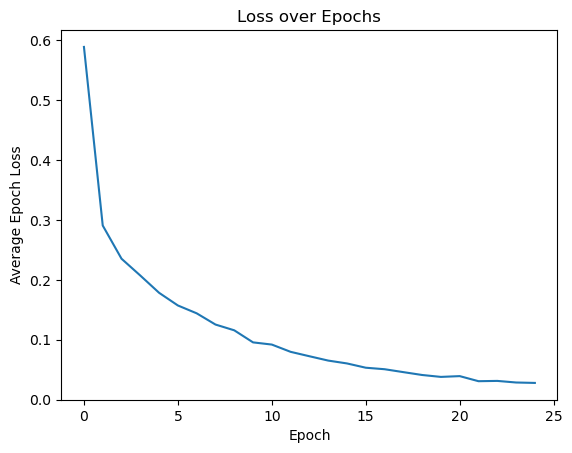

In [103]:
mdl2 = SimpleCNN_x(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(mdl2.parameters(), lr=0.001, momentum=0.8)

mdl2 = mdl2.to(device)

num_epochs = 25  
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    for i, (images, labels) in enumerate(data_loader):
        # Move data to device
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        
        # Clear out previous gradients
        optimizer.zero_grad()
        
        x1, x2, outputs = mdl2(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Update running epoch loss
        epoch_loss += loss.item()
        num_batches += 1

        # Logging
        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

        # Free up some memory after each iteration
        del images, labels, outputs, x1, x2, loss
        torch.cuda.empty_cache()

    # Compute the average loss for this epoch
    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)

# Plotting
plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()



In [104]:
def test_model_x(mdl2, test_loader):
    mdl2 = mdl2.to(device)
    
    mdl2.eval() 
    correct = 0
    total = 0
   
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        images = images.unsqueeze(1)  
        x1, x2, outputs = mdl2(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model_x(mdl2, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_13244\691292828.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 95.17%
